<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/dl_assignment2_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [1]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Fri Apr 23 14:54:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Setup logging

In [1]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [2]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Mounted at /content/gdrive
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [15]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



plot = Plot()
plot_adaptive = Plot()

## Extract train and test instances

In [13]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [14]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

def get_checkpoint_callback(name):
    checkpoint_filepath = f"/content/gdrive/MyDrive/DeepLearningAssignment2/checkpoints-{name}-checkpoint"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    callback_array = [\
                      tf.keras.callbacks.LearningRateScheduler(\
                                                        decay_after_runs(N)),
                      early_stopping,
                      term_on_nan,
                      ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

# Question 1 Part A

## Build a Baseline

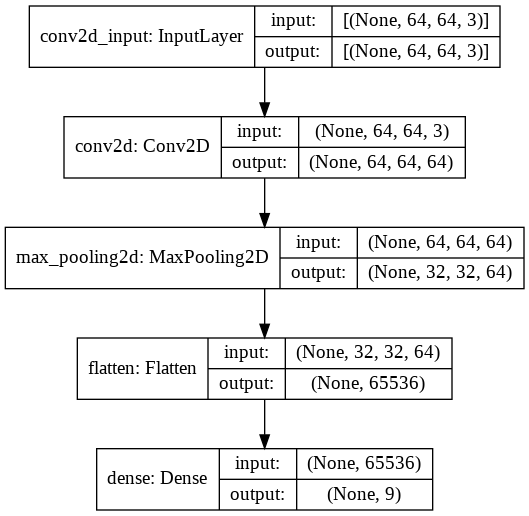

Model: "BaseLineShallowNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 9)                 589833    
Total params: 591,625
Trainable params: 591,625
Non-trainable params: 0
_________________________________________________________________
None
(19200, 64, 64, 3)
Epoch 1/100
600/600 [==============================] - 36s 6ms/step - loss: 1.5315 - accuracy: 0.4443 - val_loss: 1.1342 - val_accuracy: 0.5948
Epoch 2/100
600/600 [==============================] - 3s 5ms/step - los

In [7]:
tf.random.set_seed(5)
plot2 = Plot()
class BaselineShallowNet:
    @staticmethod
    def build(inshape, nlabels):
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

N_EPOCHS=100

model = BaselineShallowNet.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

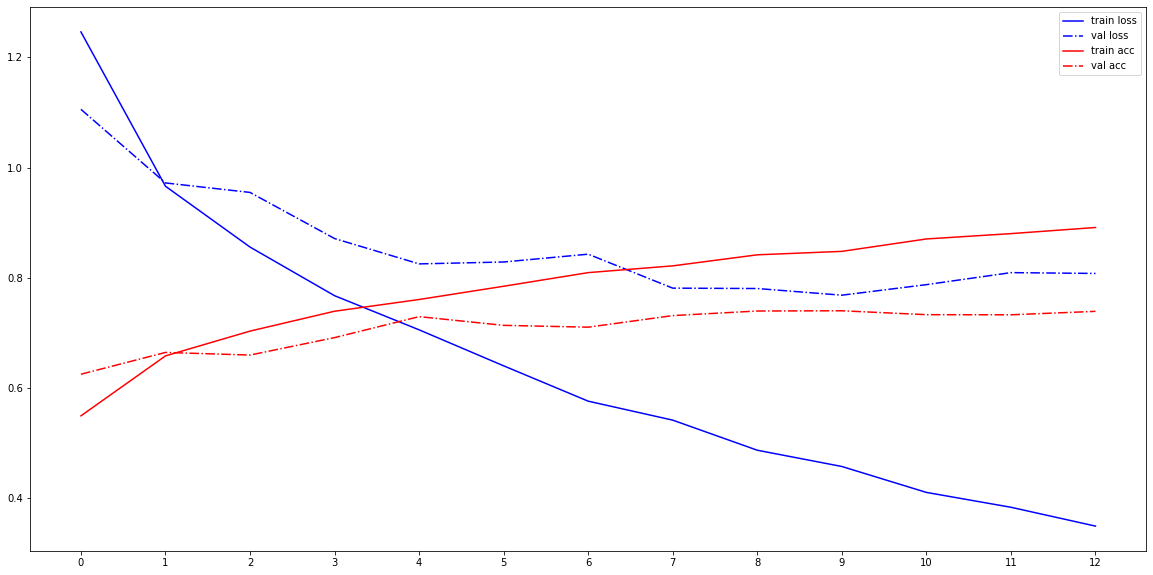

Best validation accuracy: 0.7400000095367432, epoch = 9
Best validation loss: 0.7682990431785583, epoch = 9
Best validation accuracy: 0.7400000095367432, epoch = 9
Best validation loss: 0.7682990431785583, epoch = 9


In [35]:
plot.plot_history(history, N_EPOCHS, model.name)
plot2.plot_history(history, N_EPOCHS, model.name, show=False)

### Try the same thing with an adaptive learning rate

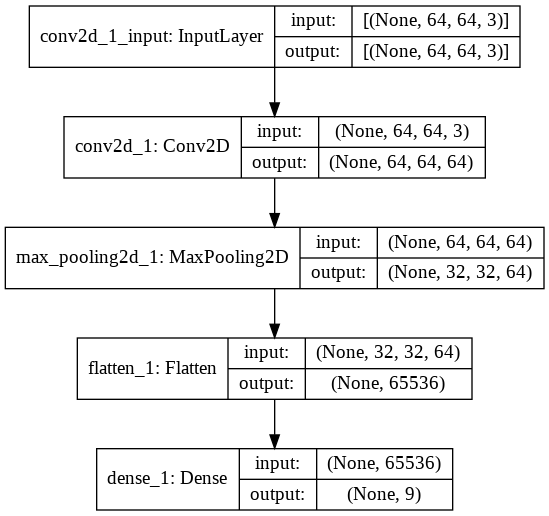

Model: "BaseLineShallowNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 589833    
Total params: 591,625
Trainable params: 591,625
Non-trainable params: 0
_________________________________________________________________
None
(19200, 64, 64, 3)
Epoch 1/100
600/600 [==============================] - 3s 5ms/step - loss: 1.4889 - accuracy: 0.4480 - val_loss: 1.0493 - val_accuracy: 0.6273
Epoch 2/100
600/600 [==============================] - 3s 5ms/step - loss

In [8]:
tf.random.set_seed(5)
model = BaselineShallowNet.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(4, model.name))

In [ ]:
plot1.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR")
plot_adaptive.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR"

#### Compare adaptive learning rate with original

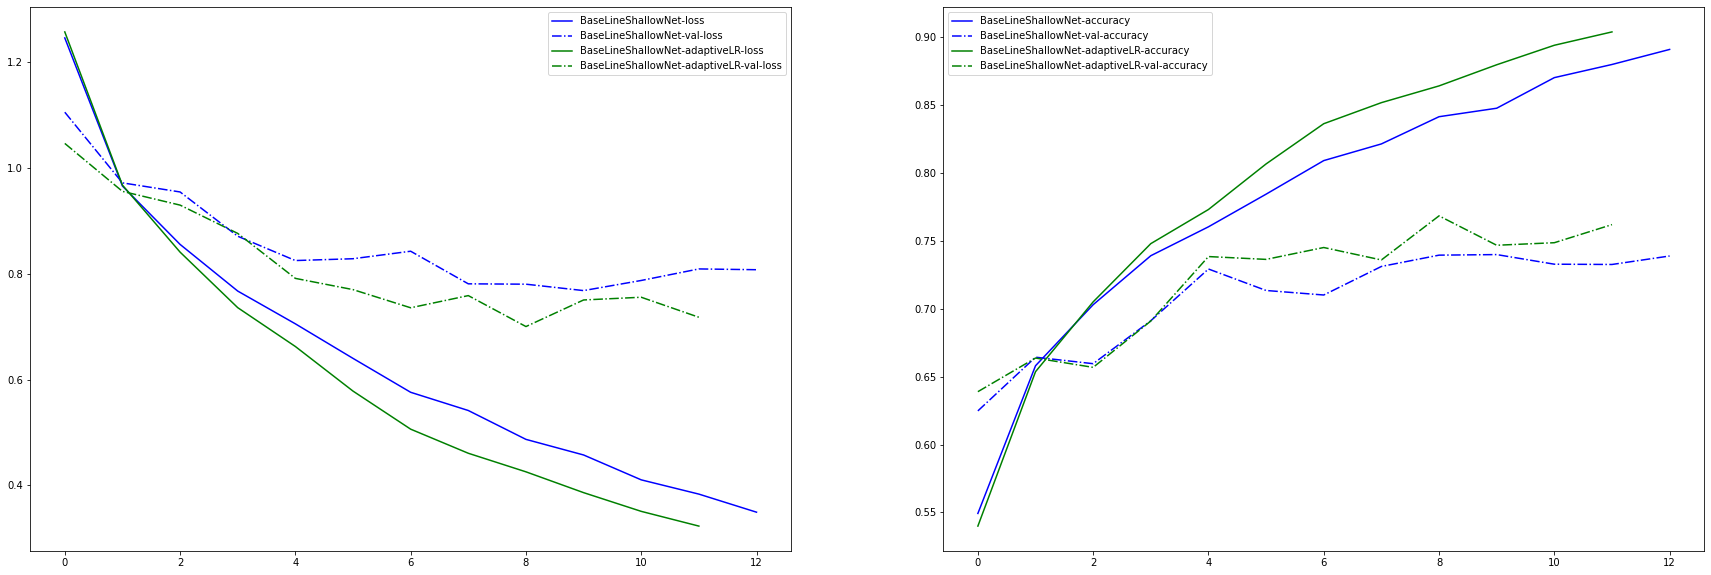

In [41]:
plot2.superplot()

## 1 Conv 2 Dense

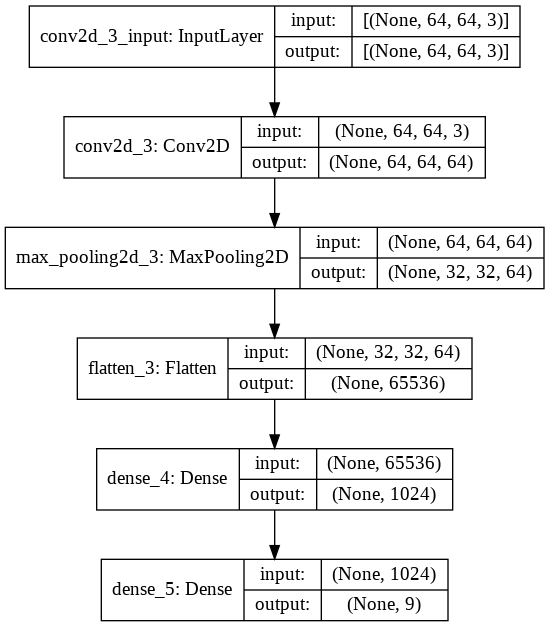

Model: "BaseLineTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              67109888  
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 9225      
Total params: 67,120,905
Trainable params: 67,120,905
Non-trainable params: 0
_________________________________________________________________
None
(19200, 64, 64, 3)
Epoch 1/100
600/600 [==============================] - 12s 20ms/step - los

In [16]:
tf.random.set_seed(5)
class BaselineTwoDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoDenseLayers")
        model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

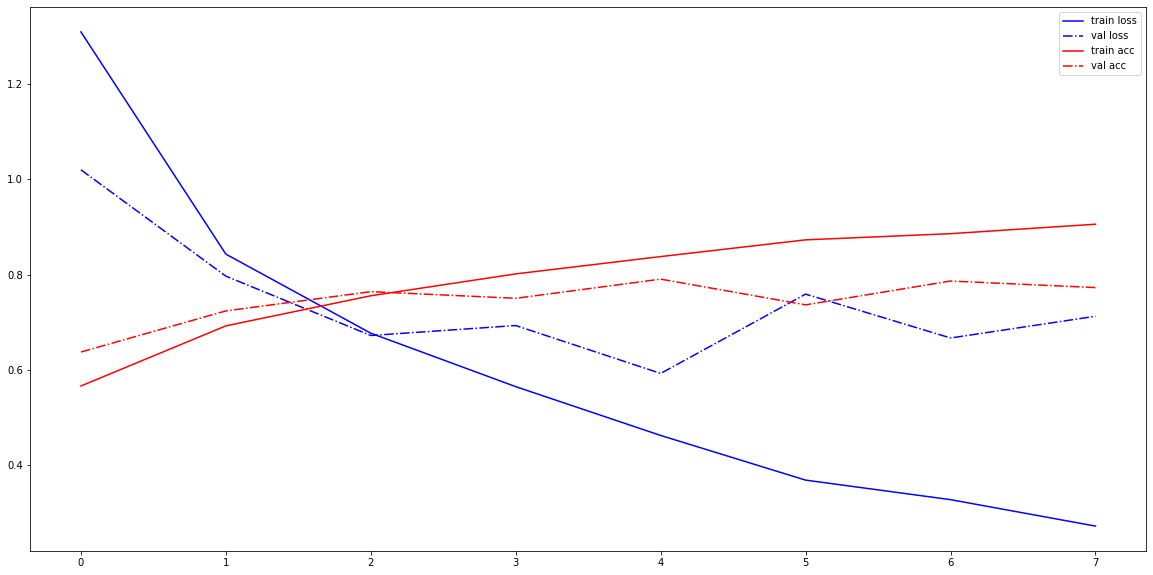

Best validation accuracy: 0.7904166579246521, epoch = 4
Best validation loss: 0.5925997495651245, epoch = 4


In [17]:
plot.plot_history(history, N_EPOCHS, model.name)
plot2 = Plot()
plot2.plot_history(history, N_EPOCHS, model.name, show=False)

### Try the same thing with adaptive learning rate

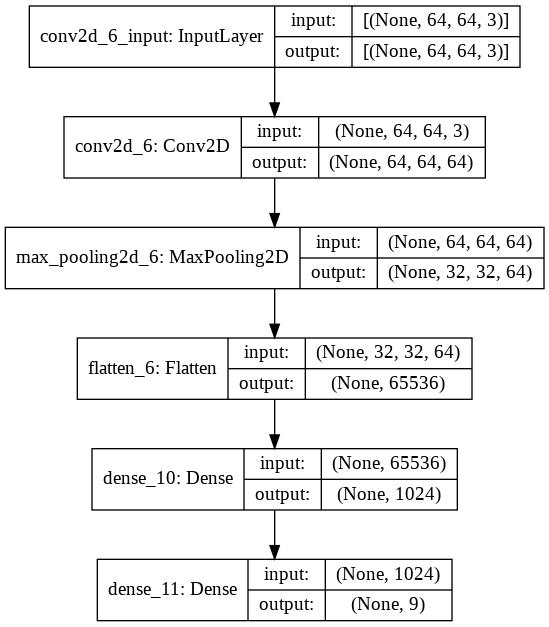

Model: "BaseLineTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              67109888  
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 9225      
Total params: 67,120,905
Trainable params: 67,120,905
Non-trainable params: 0
_________________________________________________________________
None
(19200, 64, 64, 3)
Epoch 1/100
400/600 [===================>..........] - ETA: 3s - loss: 2.1

KeyboardInterrupt: ignored

In [23]:
tf.random.set_seed(5)
model = BaselineTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(4, model.name))
plot_adaptive.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)

#### Compare adaptive learning rate with original

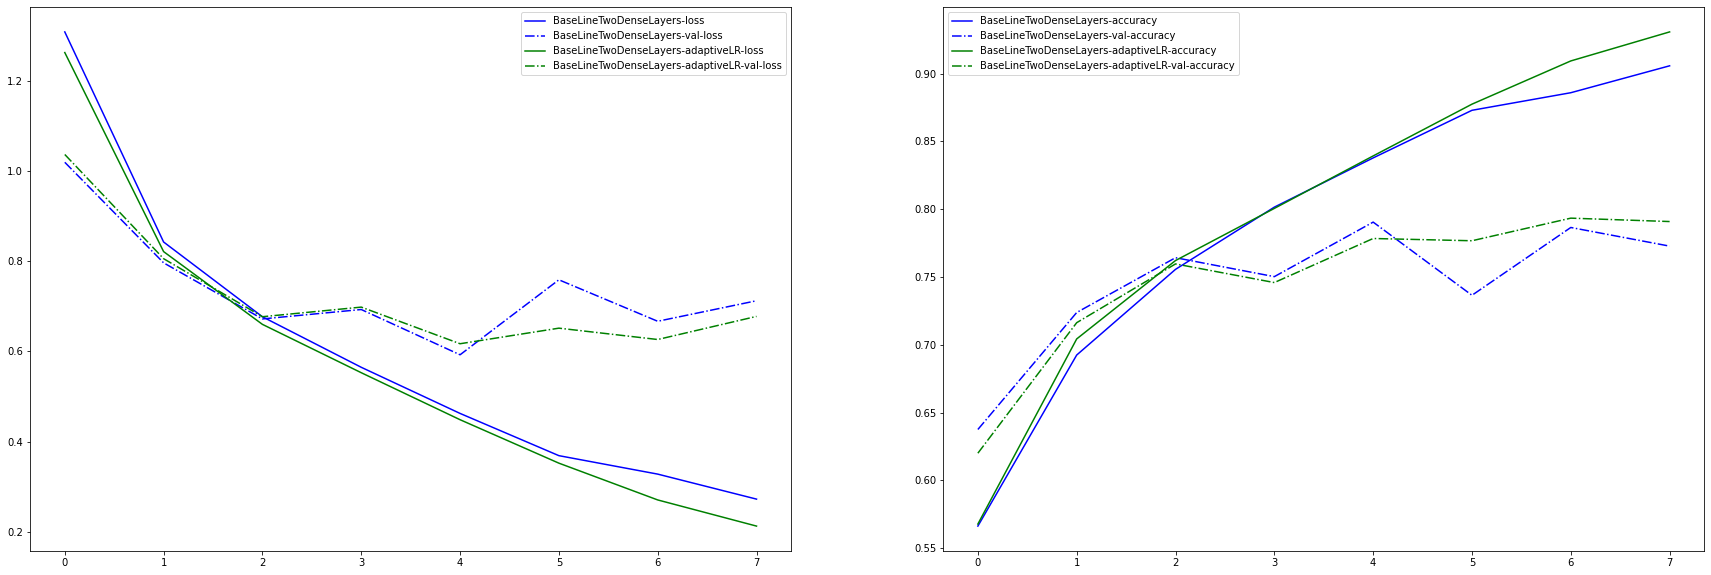

In [22]:
plot2.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)
plot2.superplot()

## 2 Conv 1 Dense Layer

(64, 64, 3) 9


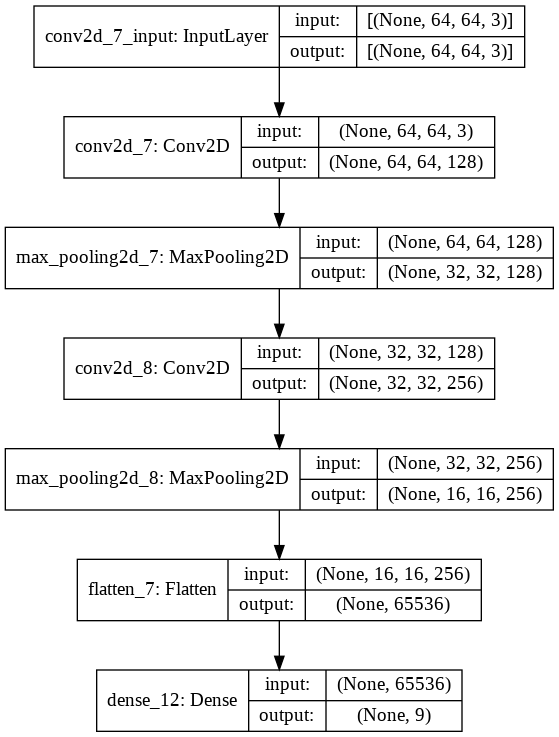

Model: "BaseLineTwoConvOneDenseLayer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 589833    
Total params: 888,585
Trainable params: 888,585
Non-trainable params: 0
________________________________

In [25]:
tf.random.set_seed(5)
class BaselineTwoConvOneDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoConvOneDenseLayer")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', \
                                         activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoConvOneDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

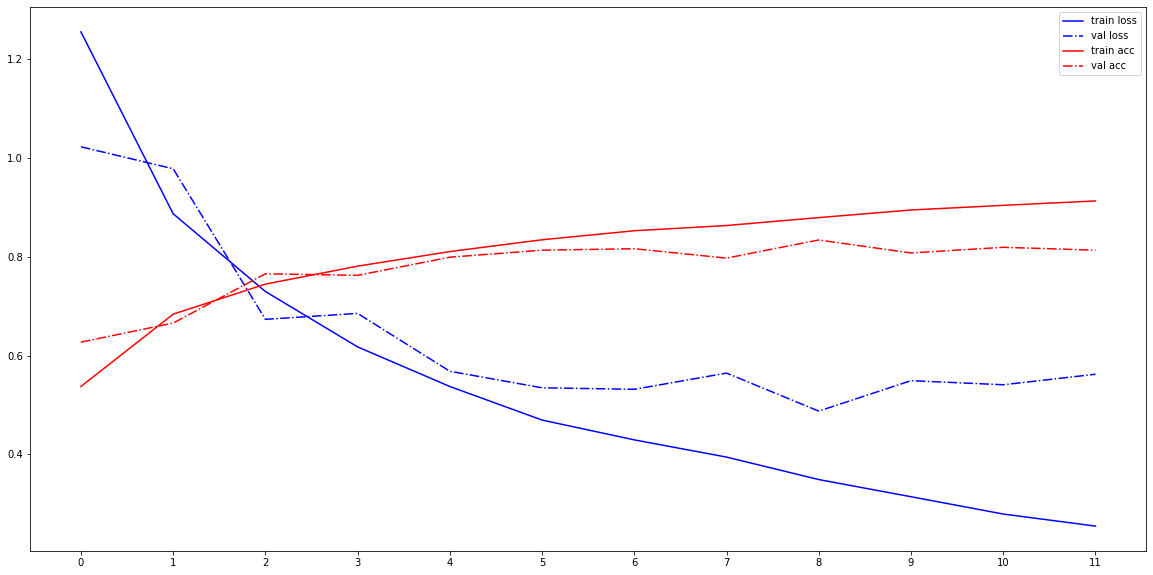

Best validation accuracy: 0.8335416913032532, epoch = 8
Best validation loss: 0.48766353726387024, epoch = 8


In [26]:
plot.plot_history(history, N_EPOCHS, model.name)

### Try the same thing with Adaptive Learning Rate

(64, 64, 3) 9


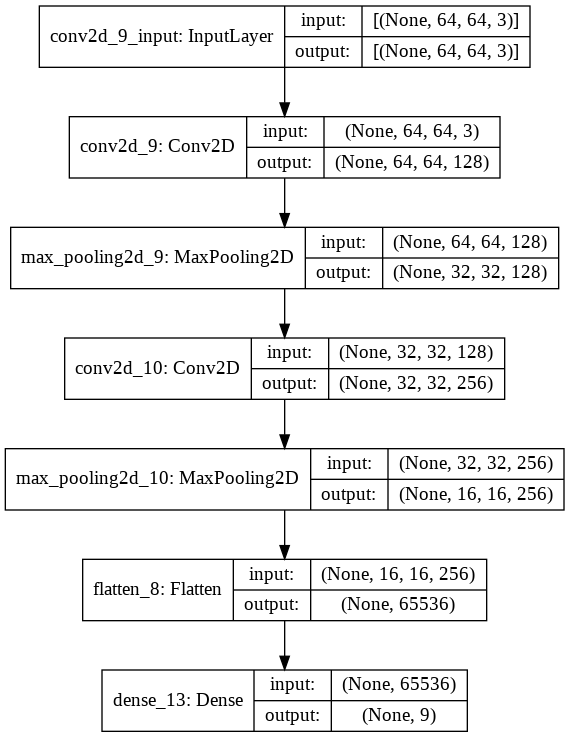

Model: "BaseLineTwoConvOneDenseLayer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 9)                 589833    
Total params: 888,585
Trainable params: 888,585
Non-trainable params: 0
________________________________

In [27]:
plot2 = Plot()
plot2.plot_history(history, N_EPOCHS, model.name, show=False)

tf.random.set_seed(5)
model = BaselineTwoConvOneDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(4, model.name))

plot_adaptive.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)

#### Compare Adaptive Learning Rate with Original

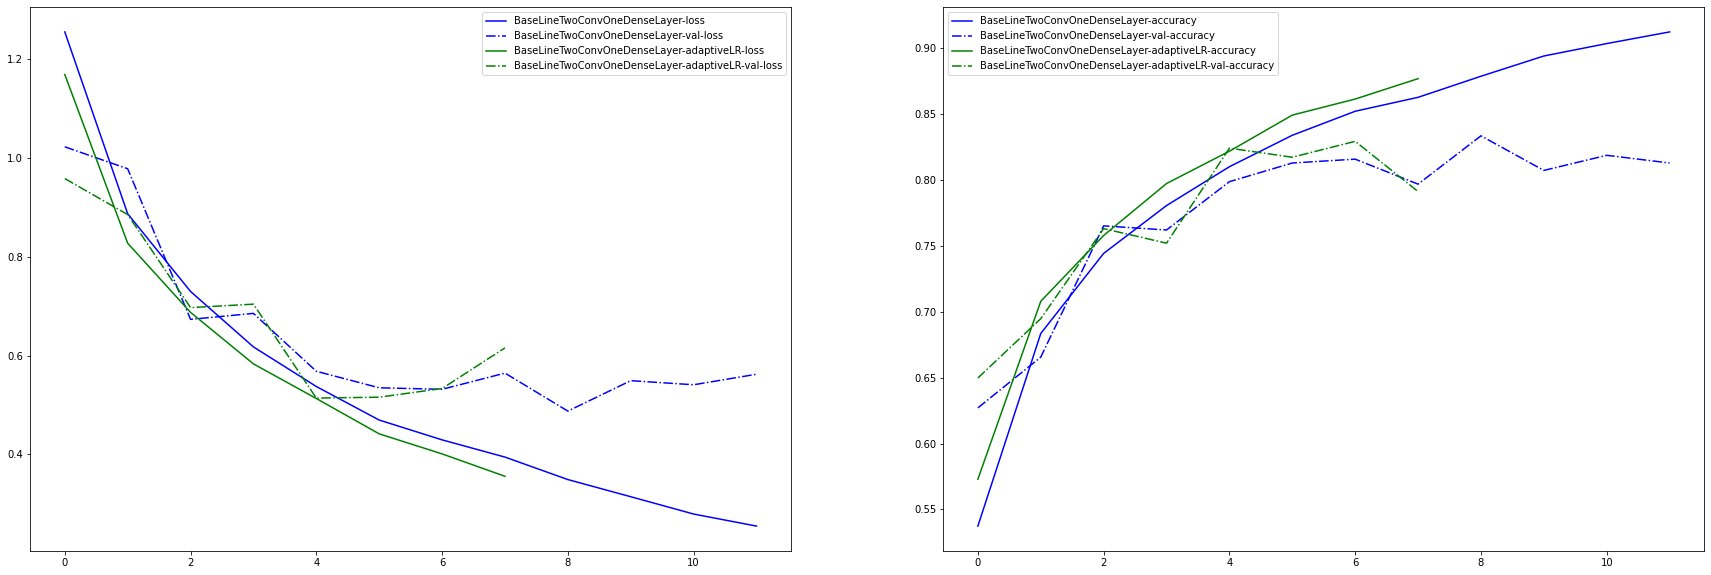

In [29]:
plot2.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)
plot2.superplot()

## 2 Conv 2 Dense Layers

(64, 64, 3) 9


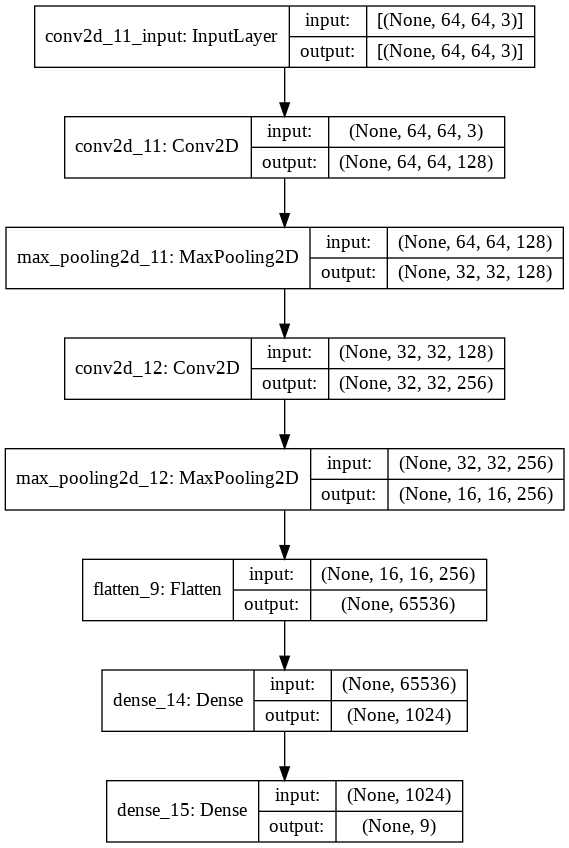

Model: "BaseLineTwoConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              67109888  
_________________________________________________________________
dense_15 (Dense)             (None, 9

In [30]:
tf.random.set_seed(5)
class BaselineTwoConvTwoDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineTwoConvTwoDenseLayers")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', \
                                         activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))

model = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

Best validation accuracy: 0.8075000047683716, epoch = 6
Best validation loss: 0.5666062235832214, epoch = 6


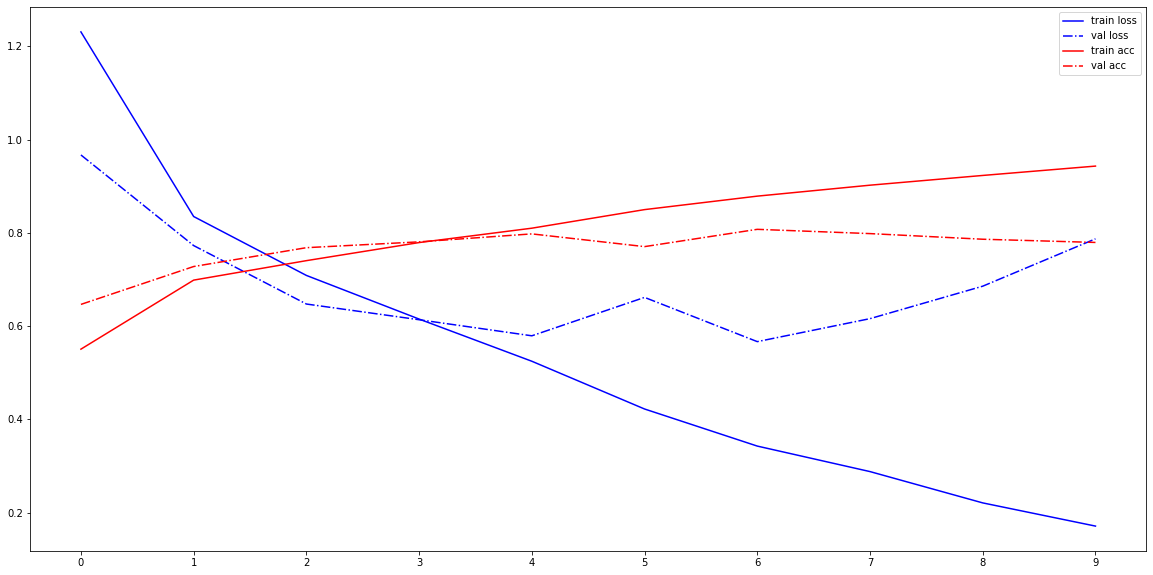

In [14]:
plot.plot_history(history, N_EPOCHS, model.name)
plot2 = Plot()
plot2.plot_history(history, N_EPOCHS, model.name, show=False)

### Try the same thing with Adaptive Learning Rate

(64, 64, 3) 9


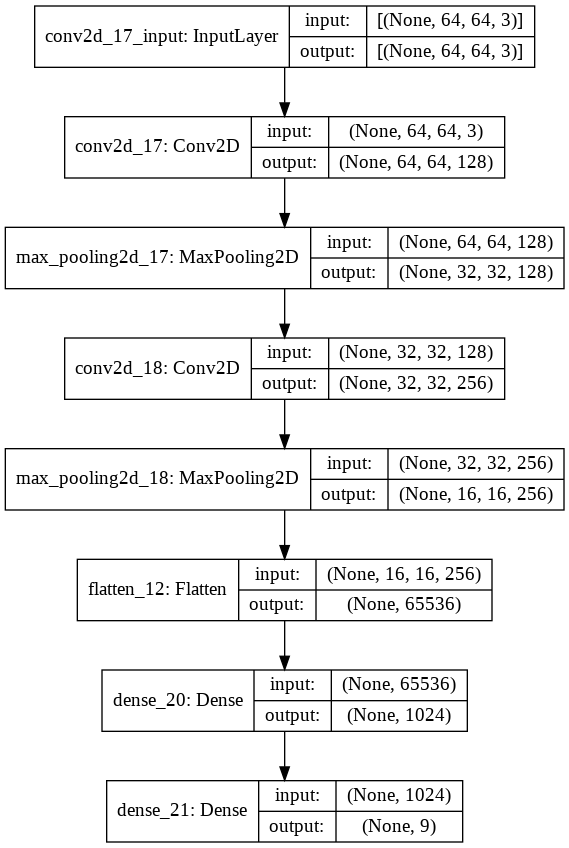

Model: "BaseLineTwoConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              67109888  
_________________________________________________________________
dense_21 (Dense)             (None, 9

In [33]:
tf.random.set_seed(5)
model = BaselineTwoConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(4, model.name))
plot_adaptive.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)

#### Compare Adaptive Learning Rate with Original

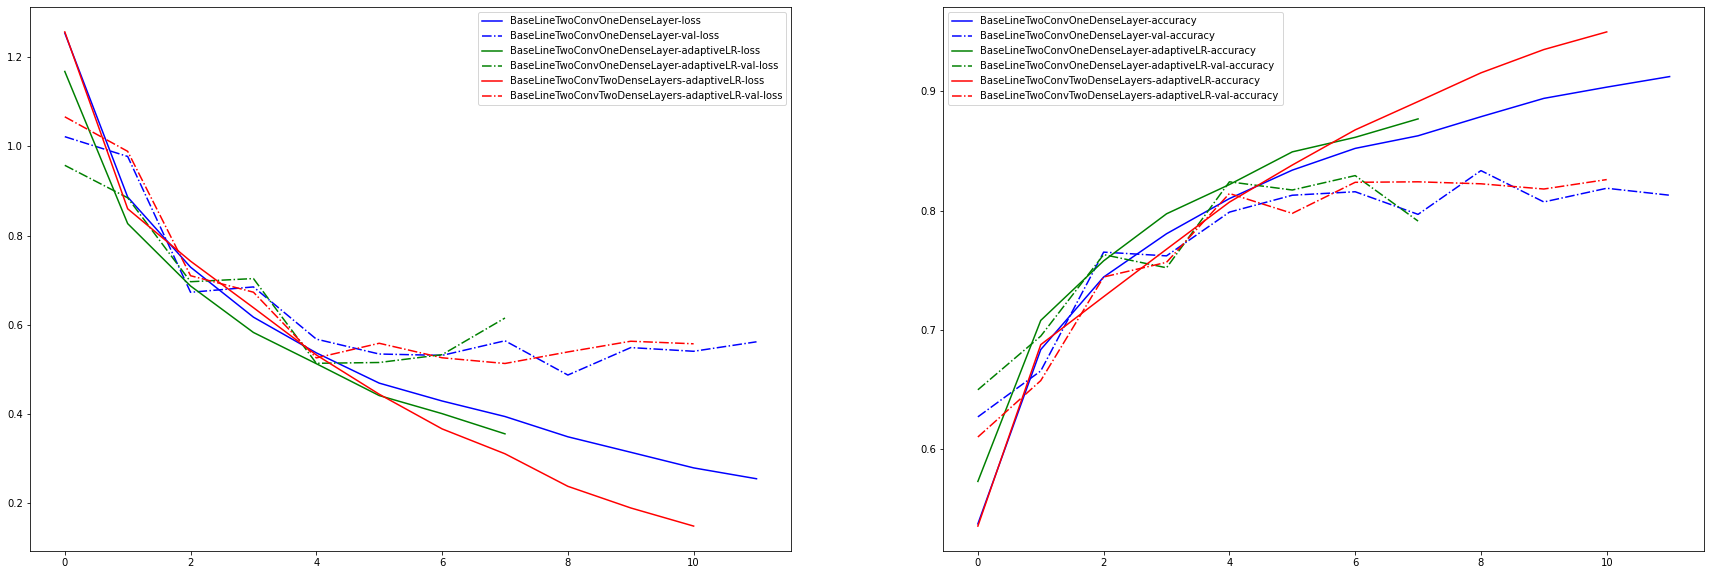

In [34]:
plot2.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)
plot2.superplot()

## 3 Conv 2 Dense Layers



(64, 64, 3) 9


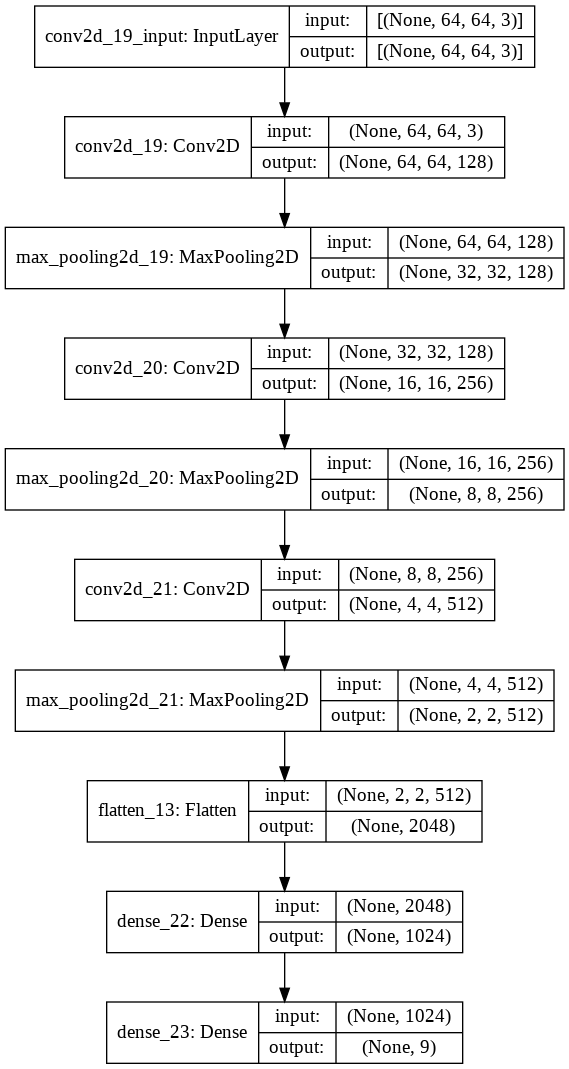

Model: "BaseLineThreeConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 512)         1180160   
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None,

In [36]:
tf.random.set_seed(5)
class BaselineThreeConvTwoDenseLayers:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineThreeConvTwoDenseLayers")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', \
                                         activation='relu', strides=(2,2)))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same', \
                                         activation='relu', strides=(2,2)))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

N_EPOCHS = 100
n_classes = len(np.unique(np.concatenate((trainY, valY))))
model = BaselineThreeConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

Best validation accuracy: 0.8766666650772095, epoch = 8
Best validation loss: 0.3719535171985626, epoch = 8


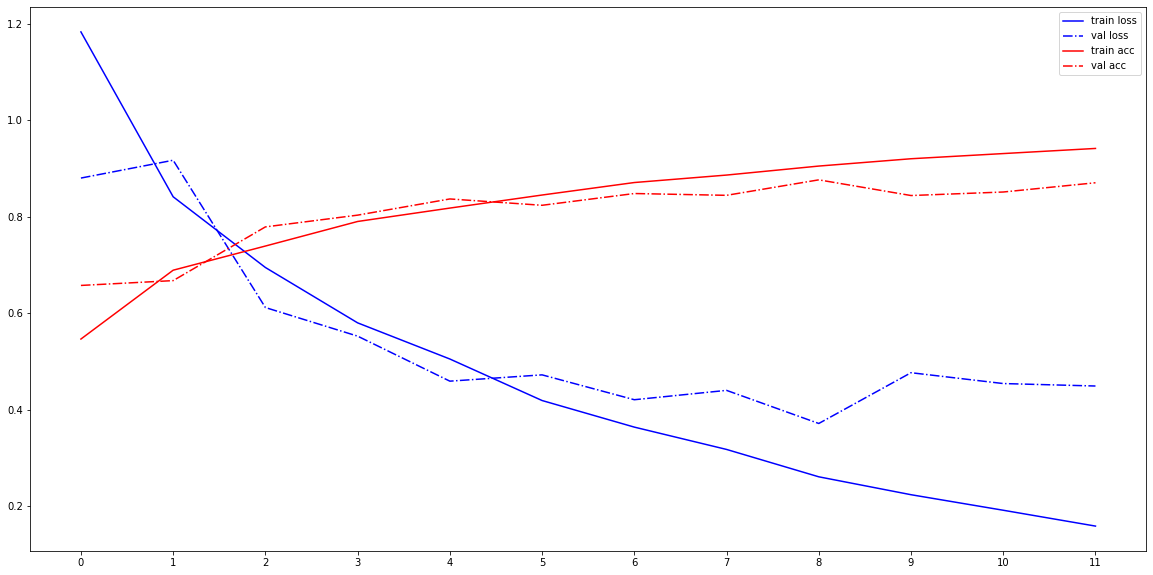

In [16]:
plot.plot_history(history, N_EPOCHS, model.name)
plot2 = Plot()
plot.plot_history(history, N_EPOCHS, model.name, show=False)

### Try the same thing with Adaptive Learning Rate

(64, 64, 3) 9


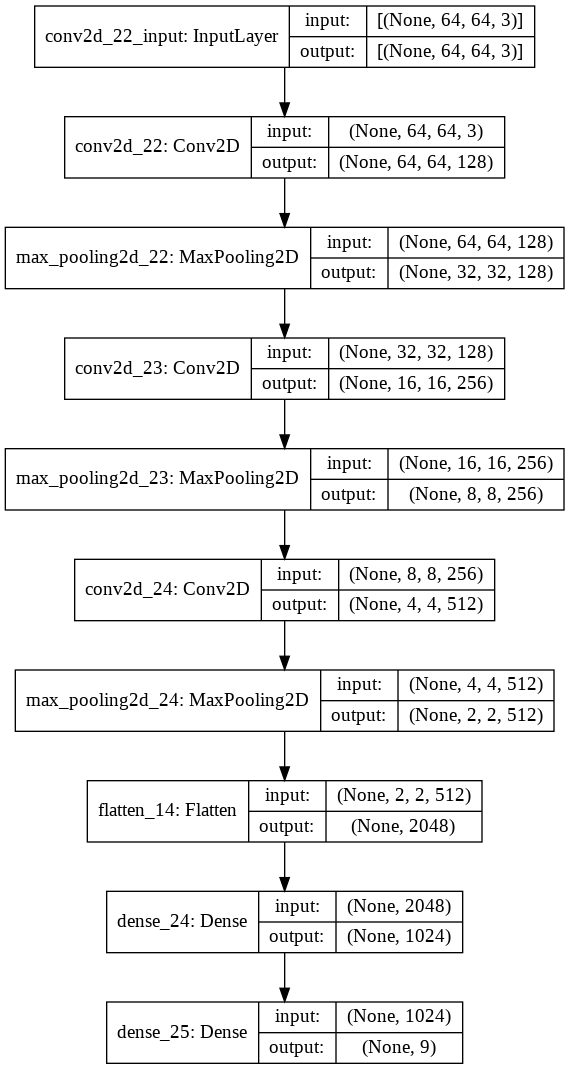

Model: "BaseLineThreeConvTwoDenseLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 512)         1180160   
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None,

KeyboardInterrupt: ignored

In [37]:
tf.random.set_seed(5)
n_classes = len(np.unique(np.concatenate((trainY, valY))))
model = BaselineThreeConvTwoDenseLayers.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(4, model.name))
plot_adaptive.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)

#### Compare Adaptive Learning Rate With Original

In [ ]:
plot2.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)
plot2.superplot()

## 3 Conv 2 Dense Layers + Dropout

(64, 64, 3) 9


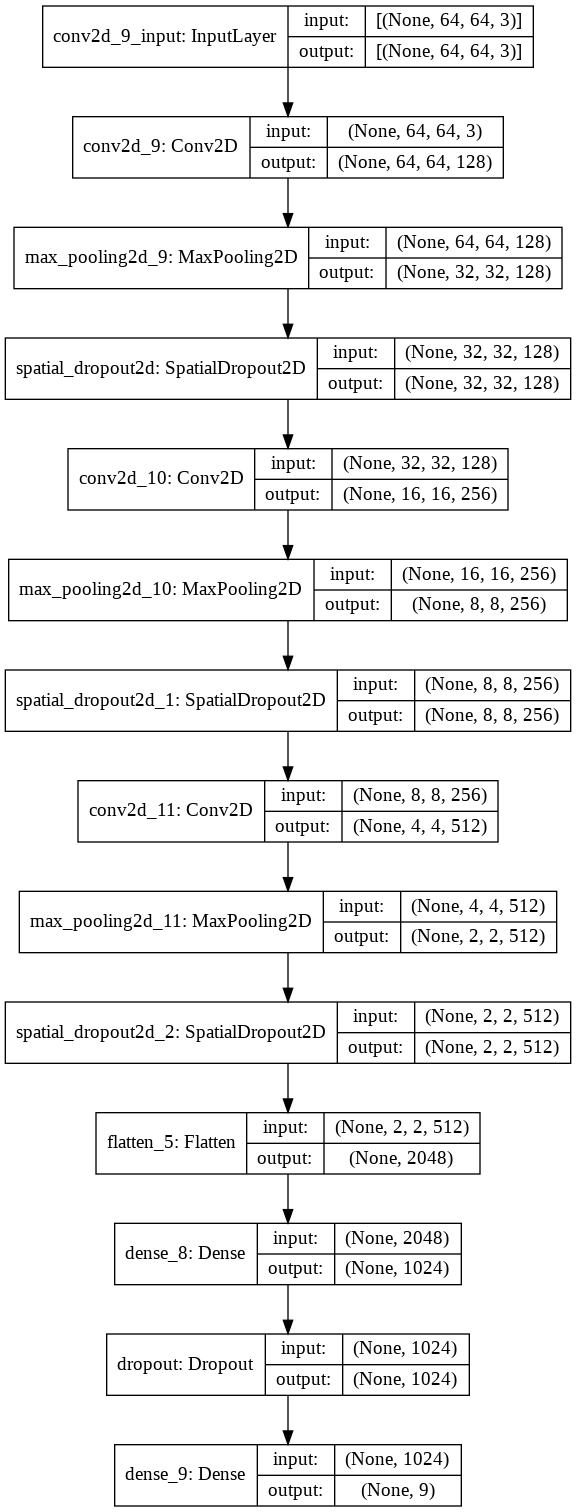

Model: "BaseLineThreeConvTwoDenseLayersDropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_11 (Conv2D)          

In [17]:
tf.random.set_seed(5)
class BaselineThreeConvTwoDenseLayersDropout:
    @staticmethod
    def build(inshape, nlabels):
        print(inshape, nlabels)
        inputShape = trainX[0].shape
        model = tf.keras.Sequential(name="BaseLineThreeConvTwoDenseLayersDropout")
        model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', \
                  input_shape=inshape, activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.SpatialDropout2D(0.25))
        model.add(tf.keras.layers.Conv2D(256, (3, 3), padding='same', \
                                         activation='relu', strides=(2,2)))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.SpatialDropout2D(0.25))
        model.add(tf.keras.layers.Conv2D(512, (3, 3), padding='same', \
                                         activation='relu', strides=(2,2)))
        model.add(tf.keras.layers.MaxPooling2D(2, 2,))
        model.add(tf.keras.layers.SpatialDropout2D(0.25))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        plot = tf.keras.utils.plot_model(model, show_shapes=True, \
                                         expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())
        return model

n_classes = len(np.unique(np.concatenate((trainY, valY))))
model = BaselineThreeConvTwoDenseLayersDropout.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(-1, model.name))

Best validation accuracy: 0.8539583086967468, epoch = 16
Best validation loss: 0.4320390820503235, epoch = 15


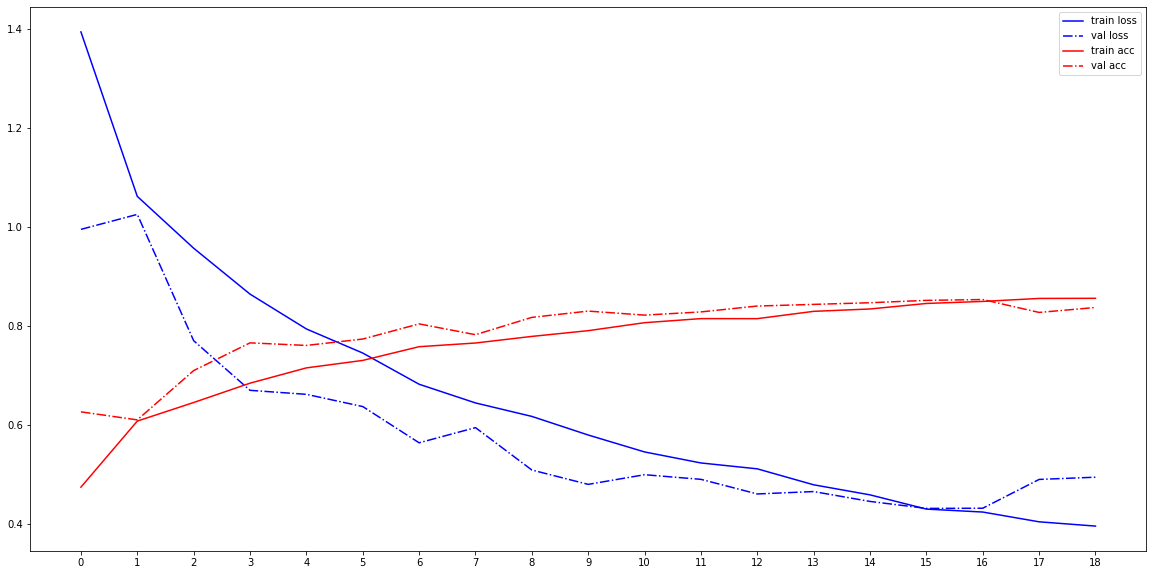

In [18]:
plot.plot_history(history, N_EPOCHS, model.name)
plot2 = Plot()
plot2.plot_history(history, N_EPOCHS, model.name, show=False)

### Try the same thing with Adaptive Learning Rate

In [ ]:
tf.random.set_seed(5)
model = BaselineThreeConvTwoDenseLayersDropout.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=get_callbacks_decay_after(4, model.name))
plot_adaptive.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)

#### Compare Adaptive Learning Rate with Original

In [ ]:
plot2.plot_history(history, N_EPOCHS, f"{model.name}-adaptiveLR", show=False)
plot2.superplot()

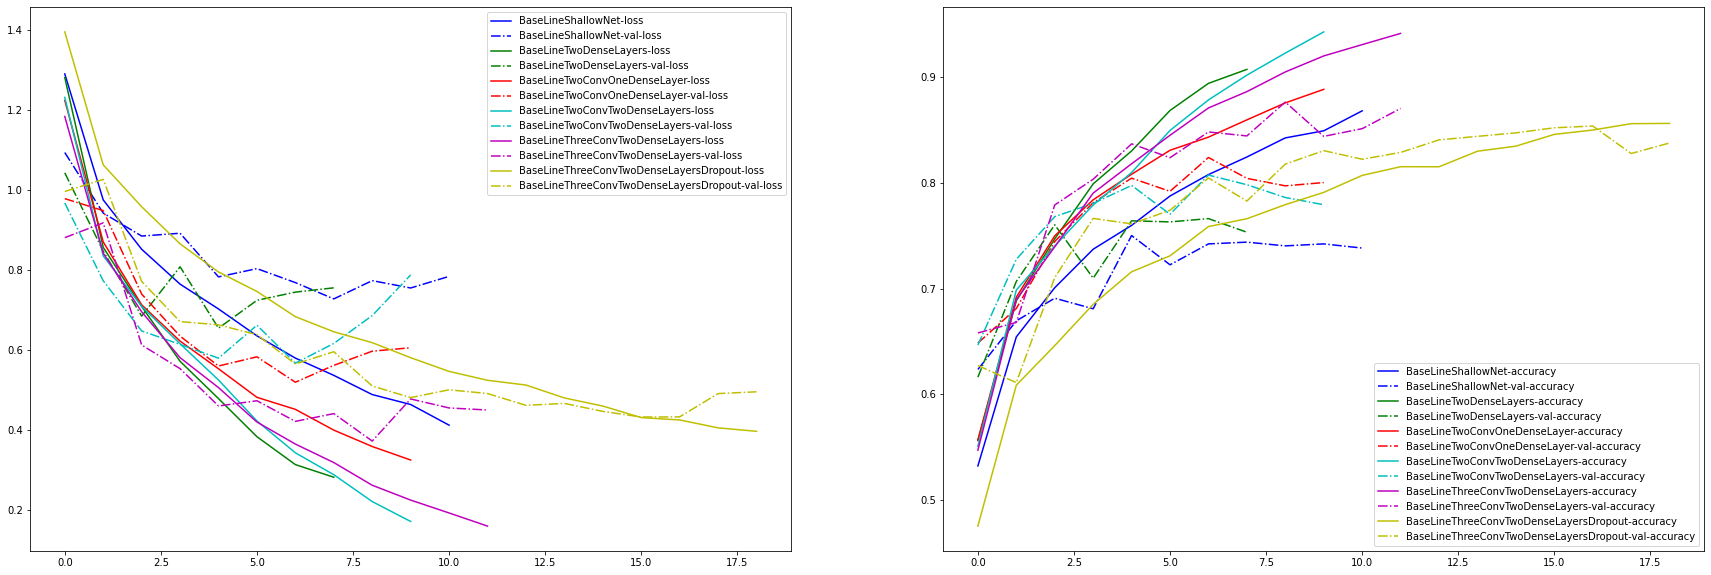

In [19]:
plot.superplot()

# Experiment with Data Augmentation

(64, 64, 3) 9


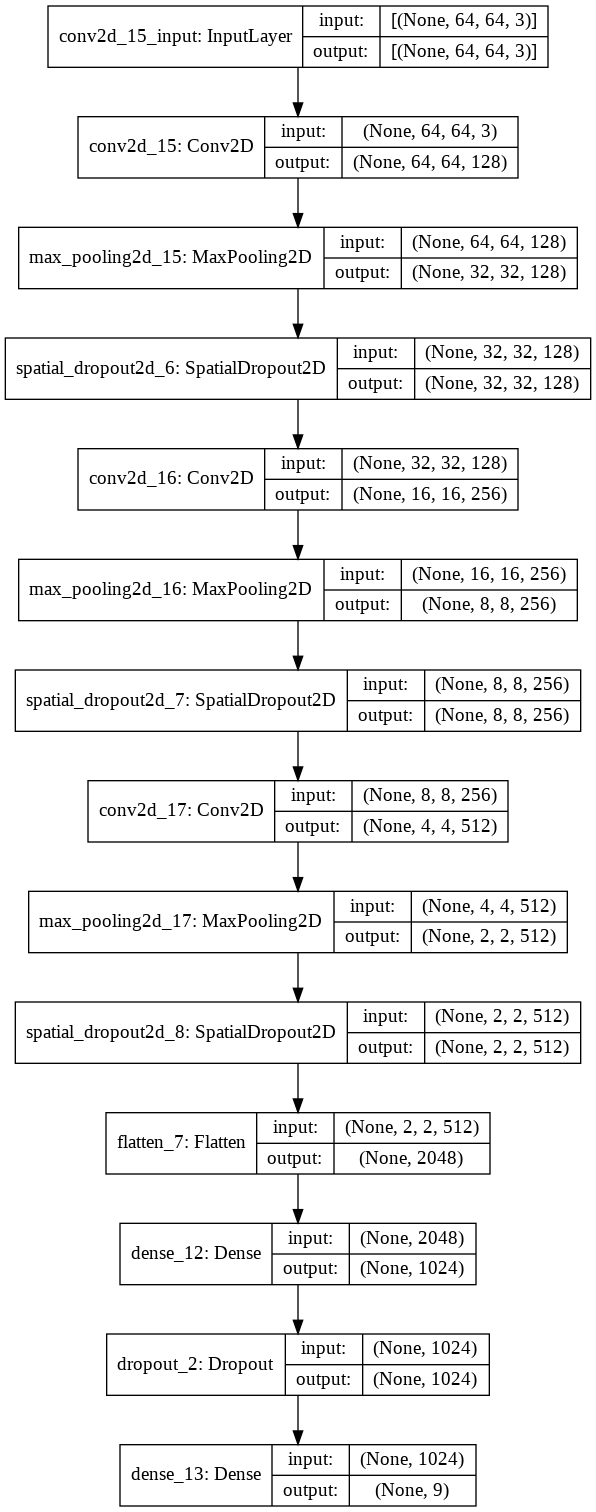

Model: "BaseLineThreeConvTwoDenseLayersDropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 128)       3584      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)          

In [24]:
train_aug = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=20,\
                                                      width_shift_range=0.1,\
                                                      shear_range=0.2,\
                                                      zoom_range=0.4,\
                                                      horizontal_flip=True)
train_generator = train_aug.flow(trainX, trainY, batch_size=32, seed=7)


"""
val_aug = tf.keras.preprocessing.image.ImageDataGenerator(\
                                                      rotation_range=20,\
                                                      width_shift_range=0.1,\
                                                      shear_range=0.2,\
                                                      zoom_range=0.4,\
                                                      horizontal_flip=True)
val_generator = val_aug.flow(valX, valY, batch_size=32, seed=7)
"""

N_EPOCHS=50

tf.random.set_seed(5)
model = BaselineThreeConvTwoDenseLayersDropout.build(tuple(trainX[0].shape), n_classes)
model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
print(trainX.shape)
"""
history = model.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=val_generator,
                    validation_steps=valX.shape[0] // 32)
"""
history = model.fit(\
                    train_generator,
                    steps_per_epoch=trainX.shape[0]//32,
                    epochs=N_EPOCHS,
                    validation_data=(valX, valY))


Best validation accuracy: 0.878125011920929, epoch = 46
Best validation loss: 0.3440045118331909, epoch = 48


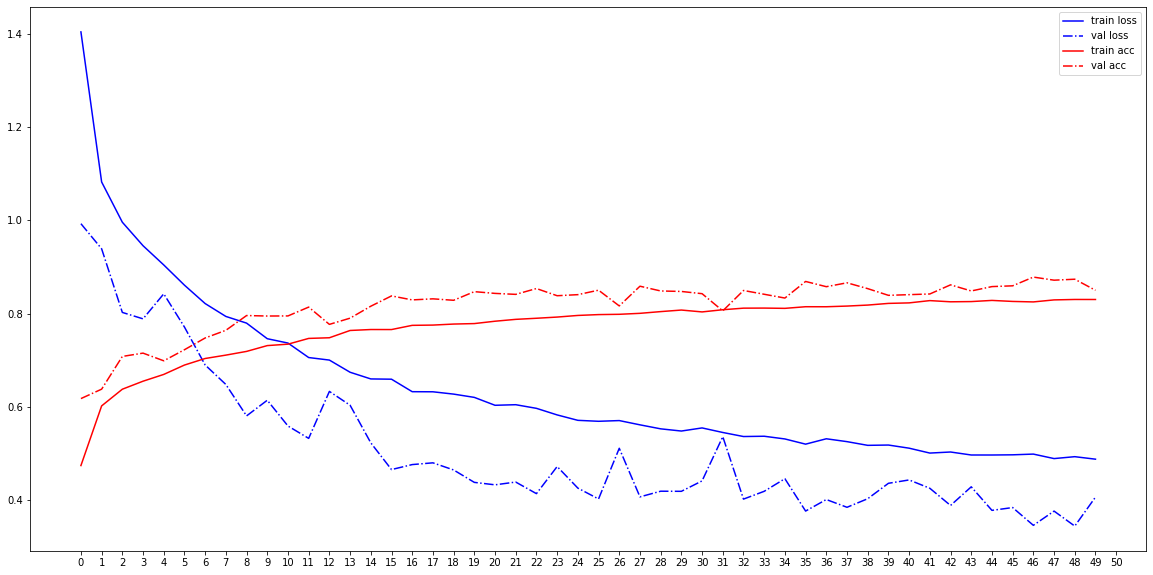

In [25]:
plot.plot_history(history, N_EPOCHS, f"{model.name}-augmented")

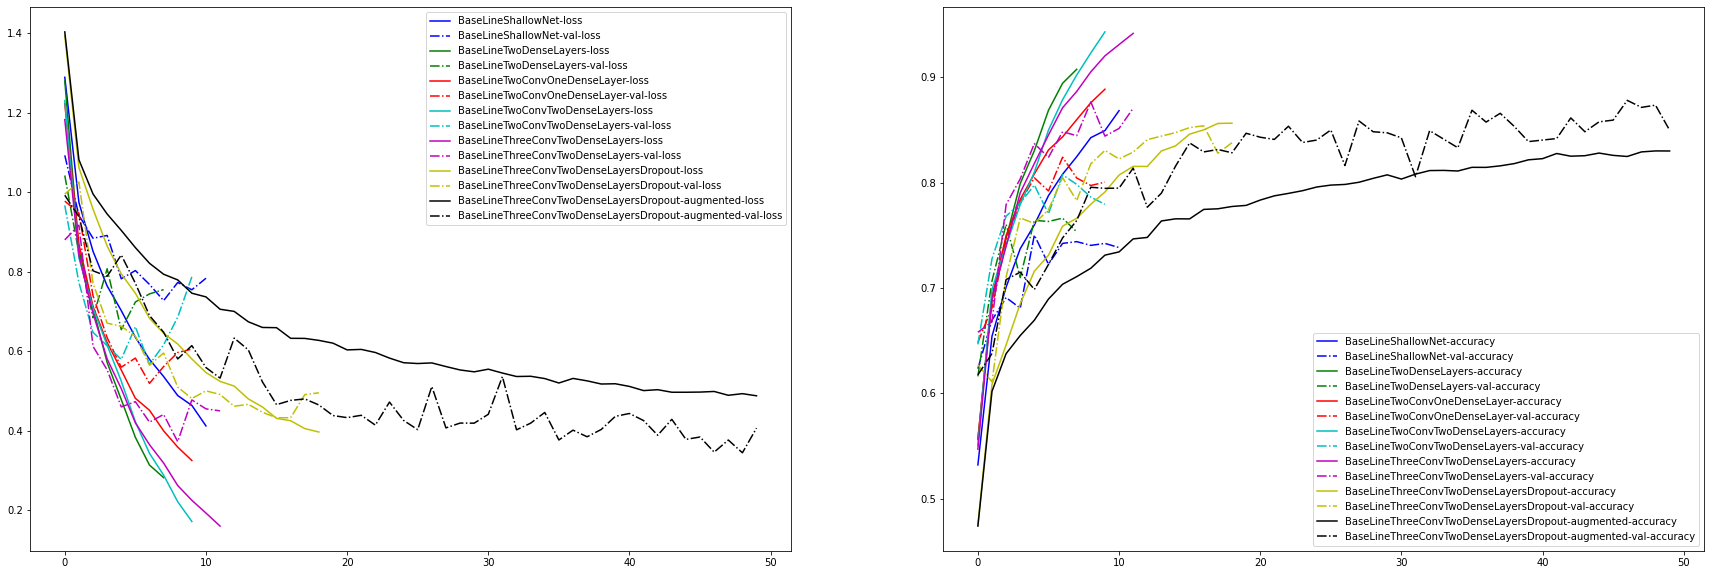

In [26]:
plot.superplot()

In [ ]:
!free -m

In [ ]:
!ps -ef | grep -i python

In [1]:
import tensorflow as tf
tf.random.set_seed(5)

In [5]:
!cd /root ; du -sh *

282M	imagedata


In [9]:
!for i in * do echo $i ; du -sh $i; done

/bin/bash: -c: line 0: syntax error near unexpected token `du'
/bin/bash: -c: line 0: `for i in * do echo $i ; du -sh $i; done'
